In [ ]:
import kagglehub

# Download and get the local dataset path (unzip if necessary)
dataset_path = kagglehub.dataset_download("paultimothymooney/blood-cells")
print("Path to dataset files:", dataset_path)

Path to dataset files: /kaggle/input/blood-cells


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [ ]:
# Paths
DATA_DIR = "/kaggle/input/blood-cells/dataset2-master/dataset2-master/images"
train_path = os.path.join(DATA_DIR, 'TRAIN')
test_path = os.path.join(DATA_DIR, 'TEST')
class_names = sorted(os.listdir(train_path))
print("Classes:", class_names)

Classes: ['EOSINOPHIL', 'LYMPHOCYTE', 'MONOCYTE', 'NEUTROPHIL']


In [ ]:

# Image transforms
img_size = 224
train_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize((img_size, img_size)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],
                         [0.229, 0.224, 0.225])
])

#  Dataset & split
full_dataset = datasets.ImageFolder(train_path, transform=train_transform)
val_dataset = datasets.ImageFolder(train_path, transform=val_transform)

indices = list(range(len(full_dataset)))
train_idx, val_idx = train_test_split(
    indices,
    test_size=0.2,
    stratify=[full_dataset.targets[i] for i in indices],
    random_state=42
)

train_data = Subset(full_dataset, train_idx)
val_data = Subset(val_dataset, val_idx)

train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16, shuffle=False)

In [ ]:
#  Load pretrained VGG16
vgg = models.vgg16(pretrained=True)

# Freeze all features
for param in vgg.features.parameters():
    param.requires_grad = False

# Replace classifier
vgg.classifier[6] = nn.Linear(4096, len(class_names))
vgg = vgg.to(device)

# Loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg.classifier.parameters(), lr=1e-4)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 200MB/s]  


In [ ]:
#Train loop
num_epochs = 10
train_losses, val_losses = [], []

for epoch in range(num_epochs):
    vgg.train()
    running_loss = 0.0
    for images, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = vgg(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    train_losses.append(running_loss / len(train_loader))

    # Validation
    vgg.eval()
    val_loss, correct, total = 0.0, 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = vgg(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
    val_losses.append(val_loss / len(val_loader))
    val_acc = correct / total
    print(f"Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}, Val Acc: {val_acc:.4f}")

Epoch 1/10: 100%|██████████| 498/498 [02:03<00:00,  4.02it/s]


Train Loss: 1.1222, Val Loss: 0.7763, Val Acc: 0.6747


Epoch 2/10: 100%|██████████| 498/498 [01:25<00:00,  5.86it/s]


Train Loss: 0.7559, Val Loss: 0.7034, Val Acc: 0.6827


Epoch 3/10: 100%|██████████| 498/498 [01:25<00:00,  5.86it/s]


Train Loss: 0.5517, Val Loss: 0.4550, Val Acc: 0.8062


Epoch 4/10: 100%|██████████| 498/498 [01:24<00:00,  5.87it/s]


Train Loss: 0.4477, Val Loss: 0.3681, Val Acc: 0.8549


Epoch 5/10: 100%|██████████| 498/498 [01:24<00:00,  5.88it/s]


Train Loss: 0.3974, Val Loss: 0.3494, Val Acc: 0.8499


Epoch 6/10: 100%|██████████| 498/498 [01:24<00:00,  5.91it/s]


Train Loss: 0.3431, Val Loss: 0.2940, Val Acc: 0.8855


Epoch 7/10: 100%|██████████| 498/498 [01:24<00:00,  5.89it/s]


Train Loss: 0.3119, Val Loss: 0.2872, Val Acc: 0.8755


Epoch 8/10: 100%|██████████| 498/498 [01:24<00:00,  5.86it/s]


Train Loss: 0.2637, Val Loss: 0.2800, Val Acc: 0.8830


Epoch 9/10: 100%|██████████| 498/498 [01:24<00:00,  5.89it/s]


Train Loss: 0.2604, Val Loss: 0.3321, Val Acc: 0.8745


Epoch 10/10: 100%|██████████| 498/498 [01:24<00:00,  5.89it/s]


Train Loss: 0.2359, Val Loss: 0.3178, Val Acc: 0.8790


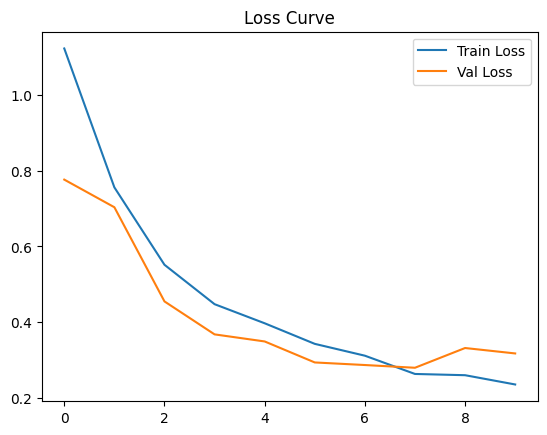

In [ ]:
# Plot loss
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss Curve")
plt.show()

In [ ]:
# Classification Report
y_true, y_pred = [], []
vgg.eval()
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = vgg(images)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

print("Classification Report:\n", classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
               precision    recall  f1-score   support

  EOSINOPHIL       0.96      0.63      0.76       499
  LYMPHOCYTE       0.89      0.99      0.93       497
    MONOCYTE       0.95      0.98      0.97       496
  NEUTROPHIL       0.76      0.92      0.83       500

    accuracy                           0.88      1992
   macro avg       0.89      0.88      0.87      1992
weighted avg       0.89      0.88      0.87      1992



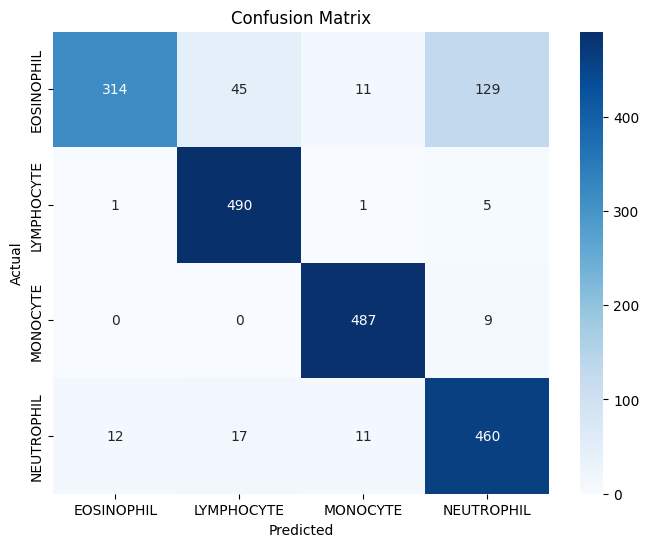

In [ ]:
#Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()